In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [18]:
## load in data separately for offense and defense (note, I cleaned up the column names in csv / excel before reading in)
dataOff = pd.read_csv('gt_offense.csv',delimiter=",")
dataDef = pd.read_csv('gt_defense.csv',delimiter=",")
data = pd.merge(dataOff,dataDef,on = ['Rk','Date','Home_Away','Opponent','Result'], how= 'inner')

In [19]:
## establish the curated response variable, we do not need the score, but only the win / loss
responseArr = [x[0] for x in np.array(data['Result']).astype(str)]
winLoss = [0 if x == "L" else 1 for x in responseArr]
data['Win_Loss'] = winLoss
data = data.drop(columns = 'Result')

In [20]:
## make the categorical feature "home_away" numerical encoding
homeAwayTransform = []
for i in np.array(data['Home_Away']).astype(str):
    if i == 'nan':
        homeAwayTransform.append(0)
    elif i == '@':
        homeAwayTransform.append(1)
    else:
        homeAwayTransform.append(2)

## home, away, neutral
homeAwayEncoding = []
for i in homeAwayTransform:
    if i == 0:
        homeAwayEncoding.append([1,0,0])
    elif i == 1:
        homeAwayEncoding.append([0,1,0])
    else:
        homeAwayEncoding.append([0,0,1])
homeAwayEncoding = np.array(homeAwayEncoding)

data.insert(2,'Home',homeAwayEncoding[:,0])
data.insert(3,'Away',homeAwayEncoding[:,1])
data.insert(4,'Neutral',homeAwayEncoding[:,2])
data = data.drop(columns = 'Home_Away')

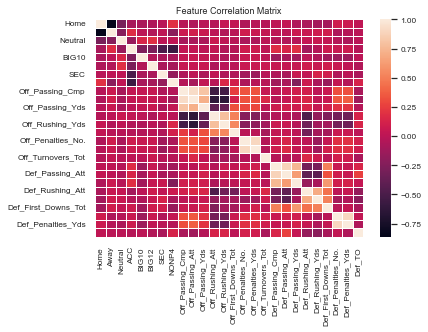

e:\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Scaled Numerical Feature,VIF
8,Off_Passing_Cmp,11.635019
9,Off_Passing_Att,10.449332
10,Off_Passing_Yds,3.617173
11,Off_Rushing_Att,6.689568
12,Off_Rushing_Yds,5.861763
13,Off_First_Downs_Tot,6.768109
14,Off_Penalties_No.,5.811898
15,Off_Penalties_Yds,6.005985
16,Off_Turnovers_Tot,1.149142
17,Def_Passing_Cmp,8.365992


In [21]:
## now we need to standardize the names for the opponents
standardizedOpps = []
for i in [x.upper() for x in data['Opponent']]:
    tempStarRemove = i.replace('*','')
    tempSplitStr = tempStarRemove.split()
    standardStr = "_".join(tempSplitStr)
    standardizedOpps.append(standardStr)
data['Opponent'] = standardizedOpps

data = data.drop(columns = ['Rk','Date','Off_Passing_Pct','Off_Passing_TD','Off_Rushing_Avg','Off_Rushing_TD','Off_Total_Offense_Avg','Off_First_Downs_Pass', 'Off_First_Downs_Rush', 'Off_First_Downs_Pen','Off_Turnovers_Fum', 'Off_Turnovers_Int','Def_Passing_Pct','Def_Passing_TD','Def_Rushing_Avg', 'Def_Rushing_TD','Def_Total_Offense_Avg','Def_First_Downs_Pass', 'Def_First_Downs_Rush','Def_First_Downs_Pen','Def_Fum', 'Def_Int','Off_Total_Offense_Plays','Off_Total_Offense_Yds','Def_Total_Offense_Plays','Def_Total_Offense_Yds'])

# ## then we can one hot encode the opponents categorical variable
# rightOfDummies = data[data.columns[6:]]
# data = data.drop(columns = list(data.columns[6:]))
# data = pd.get_dummies(data,columns =['Opponent'],dtype=int)
# data = pd.concat([data,rightOfDummies],axis=1)

ACC = ['BOSTON_COLLEGE','CLEMSON','DUKE','FLORIDA_STATE','LOUISVILLE','MIAMI_(FL)','NORTH_CAROLINA','NORTH_CAROLINA_STATE','PITTSBURGH','SYRACUSE','VIRGINIA','VIRGINIA_TECH', 'WAKE_FOREST','STANFORD']
SEC = ['AUBURN','GEORGIA','KENTUCKY','LOUISIANA_STATE','MISSISSIPPI', 'MISSISSIPPI_STATE','TENNESSEE','VANDERBILT']
BIG12 = ['BRIGHAM_YOUNG','CENTRAL_FLORIDA','KANSAS','UTAH','WEST_VIRGINIA']
BIG10 = ['IOWA','MARYLAND','MINNESOTA','SOUTHERN_CALIFORNIA']
NONP4 = list(set(np.unique(data['Opponent'])) - set(ACC+SEC+BIG12+BIG10))

## ACC, BIG10, BIG12, SEC, NONP4
confCoding = []
for i in data['Opponent']:
    if i in ACC:
        confCoding.append([1,0,0,0,0])
    if i in BIG10:
        confCoding.append([0,1,0,0,0])
    if i in BIG12:
        confCoding.append([0,0,1,0,0])
    if i in SEC:
        confCoding.append([0,0,0,1,0])
    if i in NONP4:
        confCoding.append([0,0,0,0,1])

confCoding = np.array(confCoding)
data.insert(3,'ACC',confCoding[:,0])
data.insert(4,'BIG10',confCoding[:,1])
data.insert(5,'BIG12',confCoding[:,2])
data.insert(6,'SEC',confCoding[:,3])
data.insert(7,'NONP4',confCoding[:,4])

## getting the IN PLACE Opponent Labels, DO NOT DELETE or MOVE ORDER
opponentMapping = data['Opponent']
data = data.drop(columns = ['Opponent'])


## drop any rows with missing values
data = data.dropna(axis=0)
data = data.reset_index(drop=True)

scaled = scale(np.array(data.iloc[:,:26]))

## add replace data with scaled data
for i,v in enumerate(data.columns[0:26]):
    data[f'{v}'] = scaled[:,i]
data['Opponent']=opponentMapping
## plot correlation matrix to see if multicollinearity will be a big deal
sns.set(font_scale = .75)
sns.heatmap(data.iloc[:,:26].corr(),linewidth=.5)
plt.title('Feature Correlation Matrix')
plt.show()

## check the VIF to see if multicollinearity is a problem
vifs = []
for i in range(scaled.shape[1]):
    vifs.append(variance_inflation_factor(scaled,i))

vifTable = pd.DataFrame({
    "Scaled Numerical Feature": data.columns[:26],
    "VIF": vifs 
})
vifTable = vifTable.drop(index=[0,1,2,3,4,5,6,7])
display(vifTable)

##export cleaned CSV
data.to_csv("cleanData_with_Opponent.csv",index=False)

Conclusion Points:
* Able to cut the majority of features
* One hot encoded some of the categorical features
* only 2 features had a VIF score over 10
* Showed correlation heatmap